# Прогнозирование оттока клиентов оператора связи #

## 1. Введение ##

Целью проекта является разработка модели прогнозирования оттока клиентов компании. Для достижения поставленной цели нам необходимо решить следующие задачи:
- Ознакомиться с данными, сделать первые выводы, наметить пути решения проблем, которые могут возникнуть
- Провести разведочный анализ данных
- Подготовить данные к этапу моделирования
- Подобрать несколько адекватных задаче моделей и выбрать из них лучшую
- Проверить модель на тестовой выборке и убедиться, что метрика качества достаточна для запуска модели в production
- Составить отчёт о проделанной работе

В нашем распоряжении следующие файлы с данными: 
1) информация о договорах

2) персональные данные клиентов

3) информация об интернет-услугах

4) информация об услугах телефонии

Загрузим данные в датасеты и ознакомимся с ними.

In [1]:
!pip install -q phik

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import phik
import lightgbm as lgb
import sklearn.metrics

from phik.report import plot_correlation_matrix
from phik import report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn import metrics
import lightgbm as lgb

In [44]:
df_contract = pd.read_csv('/datasets/final_provider/contract.csv')

In [5]:
df_contract.head(20)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


In [6]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Первый датасет содержит информацию о договорах. Именно в нём содержится столбец EndDate, из которого мы будем создавать целевой признак: если в столбце стоит значение 'No', значит, клиент остаётся в компании, если же стоит дата, значит, клиент ушёл. Нам необходимо будет впоследствии преобразовать столбец в бинарный признак.
Видим, что пропусков в данных нет. Но нужно будет изменить названия столбцов для более корректного вида. 

In [7]:
df_contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Метод 'describe' обработал только столбец MonthlyCharges. Стоит обратить внимание на типы данных, почти во всех столбцах это object, нам нужно будет привети их к соответствующим значениям типам: например, BeginDate преобразовать в дату, а TotalCharges - в числовой формат.  

Переходим к следующему файлу.

In [45]:
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')

In [9]:
df_personal.head(20)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


В датасете df_personal будет содержаться информация о клиентах: пол, наличие иждевенцев и т.п. 

In [10]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Вновь нет пропусков и вновь нужно будет преобразовать названия столбцов. 

Обратимся к третьему файлу.

In [46]:
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')

In [12]:
df_internet.head(20)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


In [13]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Данных меньше, чем в предыдущих датасетах. Значит, не все клиенты пользуются интернетом нашей компании. Когда мы объединим датасеты, нужно будет решать вопрос с пропусками.

Обратимся к четвёртому файлу.

In [47]:
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [15]:
df_phone.head(20)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


Четвёртый датасет содержит только информацию о том, есть ли у клиента возможность ведения параллельных линий во время звонка.

In [16]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Впрочем, датасет содержит и другую информацию: не все клиенты пользуются телефонией от нашей компании, некоторые только интернетом. Таким образом, это пересекающиеся множества, но не совпадающие. При объединении данных в единый датасет возникнут пропуски, которые нам нужно будет корректно заполнить.

Мы загрузили данные и первично ознакомились с ними. Можно переходить к плану работы.

## 2. План работы ##

1. Знакомство с данными (этот этап мы уже выполнили):
    - Постановка цели и задач проекта
    - Загрузка данных из файлов в датасеты
    - Ознакомление с данными
    - Первичный анализ данных
    - Составление плана работы
2. Разведочный анализ:
    - Объединение данных в единый датасет
    - Подготовка данных (работа с пропусками, дубликатами, типами данных, названиями столбцов...)
    - Исследовательский анализ данных, поиск и формулирование инcайтов, постановка гипотез, поиск закономерностей в данных, а также визуализация приведённых процессов
    - Формулирование "портрета" уходящего клиента
    - Создание новых признаков из имеющихся данных
    - Проверка мультиколлинеарности признаков и последующий отбор признаков на этом основании (для предотвращения утечки)
3. Подготовка данных к моделированию:
    - Разделение датасета на обучающую и тестовую выборки
    - Кодирование категориальных признаков
    - Выбор нескольких моделей, подбор гиперпараметров, используя кроссвалидацию, обучение моделей
    - Сравнение результатов моделей и выбор лучшей
    - Проверка лучшей модели на тестовой выборке. Исследование результатов через метрику ROC_AUC (метрика должна быть не меньше 0,85) и accuracy
    - Построение матрицы ошибок
    - Анализ важности признаков лучшей модели
4. Подготовка отчёта:
    - Обоснование перечня выбранных для обучения признаков и описание их преодобработки
    - Итоги обучения моделей (таблица с результатами и оценками моделей по кросс-валидации)
    - Описание лучшей модели и её гиперпараметров
    - График важности признаков
    - Выводы проекта

## 3. Анализ данных ##

Объединим все данные в один датасет.

In [48]:
df = pd.merge(df_contract, df_personal, how='outer', on='customerID')
df = pd.merge(df, df_internet, how='outer', on='customerID')
df = pd.merge(df, df_phone, how='outer', on='customerID')

In [18]:
df.head(20)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Приведём названия столбцов к корректному виду.

In [49]:
df.rename(columns={'customerID': 'customer_id', 
                   'BeginDate': 'begin_date', 
                   'EndDate':'end_date', 
                   'PaperlessBilling':'paperless_billing', 
                   'PaymentMethod':'payment_method', 
                   'MonthlyCharges':'monthly_charges', 
                   'TotalCharges':'total_charges', 
                   'SeniorCitizen':'senior_citizen',
                   'OnlineSecurity':'online_security',
                   'OnlineBackup':'online_backup',
                   'DeviceProtection':'device_protection',
                   'TechSupport':'tech_support',
                   'StreamingTV':'streaming_tv',
                   'StreamingMovies':'streaming_movies',
                   'MultipleLines':'multiple_lines',
                   'InternetService':'internet_service'}, inplace=True)
df.columns = [x.lower() for x in df.columns]

In [21]:
df.head(20)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No


В столбце begin_date даты хранятся в формате object. Переведём их в формат для дат

In [50]:
df['begin_date'] = pd.to_datetime(df['begin_date'], format='%Y-%m-%d')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

В столбце senior_citizen данные хранятся в формате int. Переведём их в object. 

In [51]:
df['senior_citizen']=df['senior_citizen'].astype(str)

В столбце total_charges данные хранятся в формате object, их нужно перевести в формат float. Метод to_numeric не сработал с первого раза, так как, как выяснилось, среди значений есть пробелы. Посчитаем, сколько их.

In [52]:
len(df[df['total_charges'] == ' '])

11

Всего 11 строк. Удалим их. 

In [53]:
df = df[df.total_charges != ' ']

In [54]:
df['total_charges'] = pd.to_numeric(df['total_charges'])

Проверим пропуски в данных.

In [28]:
df.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1520
online_security      1520
online_backup        1520
device_protection    1520
tech_support         1520
streaming_tv         1520
streaming_movies     1520
multiple_lines        680
dtype: int64

Пропуски в столбце total_charges заменим заглушкой n\a (была идея посчитать, сколько месяцев клиент находится в базе, и умножить на месячный платёж, но мы не знаем, пользовался ли он услугами и, соответственно, платил непрерывно или нет, и менялись ли его тарифные планы).
Пропуски в столбцах, связанных с интрнетом, появились потому, что просто не все клиенты, которые пользуются телефонией, также пользуются и интернетом. Поэтому тоже заменим пропуски заглушкой. 
Пропуски в столбце multiple_lines скорее всего связаны с тем, что у клиента недостпуна возможность ведения параллельных линий во время звонка. Поэтому заменим их значением no.

In [55]:
df['multiple_lines'].fillna('No',inplace=True)
df.fillna('n/a',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   object        
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   object        
 10  partner            7032 non-null   object        
 11  dependents         7032 non-null   object        
 12  internet_service   7032 non-null   object        
 13  online_security    7032 non-null   object        
 14  online_b

Проверим, есть ли в данных дубликаты

In [56]:
df.duplicated().sum()

0

Создадим дополнительный столбец - время "жизни" клиента в компании: вычтем из даты окончания контракта дату его начала. В тех случаях, когда контракт не закончился, временно замним No на дату выгрузки данных.  

In [57]:
df.loc[df['end_date'] == 'No', 'end_date'] = '2020-02-01 00:00:00'
df['end_date'] = pd.to_datetime(df['end_date'], format = '%Y-%m-%d %H:%M:%S')
df['life_time'] = df['end_date'] - df['begin_date']

In [32]:
df.head(20)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,life_time
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,DSL,No,Yes,No,No,No,No,No,31 days
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,1036 days
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,61 days
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,No,1371 days
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,61 days
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,Female,0,...,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,245 days
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Male,0,...,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,671 days
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,301.90,Female,0,...,No,DSL,Yes,No,No,No,No,No,No,306 days
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,...,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,853 days
9,6388-TABGU,2014-12-01,2020-02-01,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,...,Yes,DSL,Yes,Yes,No,No,No,No,No,1888 days


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   customer_id        7032 non-null   object         
 1   begin_date         7032 non-null   datetime64[ns] 
 2   end_date           7032 non-null   datetime64[ns] 
 3   type               7032 non-null   object         
 4   paperless_billing  7032 non-null   object         
 5   payment_method     7032 non-null   object         
 6   monthly_charges    7032 non-null   float64        
 7   total_charges      7032 non-null   float64        
 8   gender             7032 non-null   object         
 9   senior_citizen     7032 non-null   object         
 10  partner            7032 non-null   object         
 11  dependents         7032 non-null   object         
 12  internet_service   7032 non-null   object         
 13  online_security    7032 non-null   object       

Создадим ещё два столбца: дни в качестве клиента (переведём timedelta64 во float) и месяцы (разделим дни на 30).

In [58]:
df['days'] = df.apply(lambda row: row.life_time.days, axis=1)
df['days'] = pd.to_numeric(df['days'], downcast='signed')
df = df.drop(columns='life_time')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   datetime64[ns]
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   object        
 10  partner            7032 non-null   object        
 11  dependents         7032 non-null   object        
 12  internet_service   7032 non-null   object        
 13  online_security    7032 non-null   object        
 14  online_b

Теперь столбец end_date в формат целевого признака - 0 и 1: 0 - клиент остался, 1 - клиент ушёл.

In [59]:
df.loc[(df['end_date'] == '2020-02-01 00:00:00'), 'end_date'] = 0
df.loc[df['end_date'] != 0, 'end_date'] = 1
df['target'] = df['end_date']
df['target'] = df['target'].astype('float')
df = df.drop(['end_date', 'customer_id'], axis='columns')

In [38]:
df.head(20)

,begin_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,days,target
0,2020-01-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,31,0
1,2017-04-01,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036,0
2,2019-10-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,61,1
3,2016-05-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371,0
4,2019-09-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,61,1
5,2019-03-01,Month-to-month,Yes,Electronic check,99.65,820.50,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,245,1
6,2018-04-01,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,671,0
7,2019-04-01,Month-to-month,No,Mailed check,29.75,301.90,Female,0,No,No,DSL,Yes,No,No,No,No,No,No,306,0
8,2017-07-01,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,853,1
9,2014-12-01,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No,1888,0


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7032 non-null   datetime64[ns]
 1   type               7032 non-null   object        
 2   paperless_billing  7032 non-null   object        
 3   payment_method     7032 non-null   object        
 4   monthly_charges    7032 non-null   float64       
 5   total_charges      7032 non-null   float64       
 6   gender             7032 non-null   object        
 7   senior_citizen     7032 non-null   object        
 8   partner            7032 non-null   object        
 9   dependents         7032 non-null   object        
 10  internet_service   7032 non-null   object        
 11  online_security    7032 non-null   object        
 12  online_backup      7032 non-null   object        
 13  device_protection  7032 non-null   object        
 14  tech_sup

Переходим к исследовательскому анализу данных.

In [60]:
#Выделим в отдельные выборки данные по ушедшим клиентам и по оставшимся
df_1 = df[df.target == 1]
df_0 = df[df.target == 0]

Сначала проанализируем категориальные признаки

In [22]:
df_gender = df['gender'].value_counts(normalize = True)
df_gender

Male      0.504693
Female    0.495307
Name: gender, dtype: float64

<AxesSubplot:ylabel='gender'>

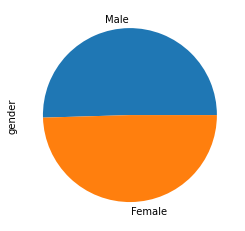

In [63]:
df.gender.value_counts().plot(kind='pie')

Пол распределён в данных примерно одинаково. 

In [64]:
df_senior = df['senior_citizen'].value_counts(normalize = True)
df_senior

0    0.8376
1    0.1624
Name: senior_citizen, dtype: float64

<AxesSubplot:ylabel='senior_citizen'>

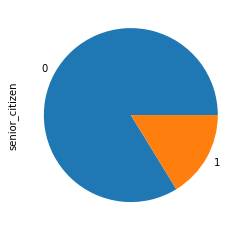

In [65]:
df.senior_citizen.value_counts().plot(kind='pie')

Пенсионеров всего 16%

In [66]:
df_partner = df['partner'].value_counts(normalize = True)
df_partner

No     0.517491
Yes    0.482509
Name: partner, dtype: float64

<AxesSubplot:ylabel='partner'>

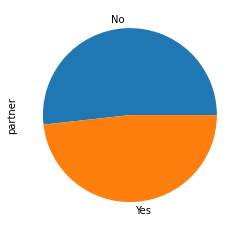

In [67]:
df.partner.value_counts().plot(kind='pie')

Женатые и неженатые клиенты в данных представлены практически равномерно. 

In [68]:
df_dependents = df['dependents'].value_counts(normalize = True)
df_dependents

No     0.701507
Yes    0.298493
Name: dependents, dtype: float64

<AxesSubplot:ylabel='dependents'>

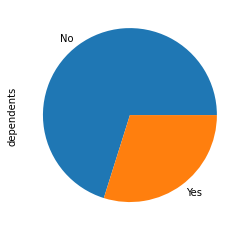

In [69]:
df.dependents.value_counts().plot(kind='pie')

Иждевенцы есть только у 30% клиентов.

In [70]:
df_payment_method = df['payment_method'].value_counts(normalize = True)
df_payment_method

Electronic check             0.336320
Mailed check                 0.228100
Bank transfer (automatic)    0.219283
Credit card (automatic)      0.216297
Name: payment_method, dtype: float64

<AxesSubplot:ylabel='payment_method'>

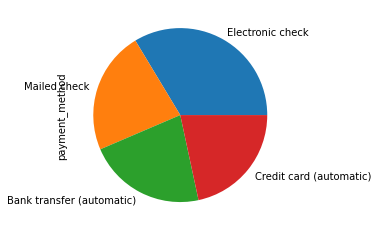

In [71]:
df.payment_method.value_counts().plot(kind='pie')

Больше клиентов (33%) предпочетают электронные чеки. Остальные способы оплаты распределены примерно поравну (около 21-22%).

In [72]:
df_paperless_billing = df['paperless_billing'].value_counts(normalize = True)
df_paperless_billing

Yes    0.592719
No     0.407281
Name: paperless_billing, dtype: float64

<AxesSubplot:ylabel='paperless_billing'>

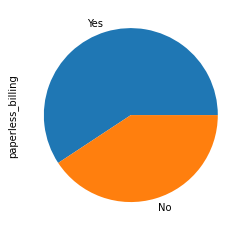

In [73]:
df.paperless_billing.value_counts().plot(kind='pie')

Большинство клиентов (59%) предпочетают безналичный расчет. 

In [74]:
df_type = df['type'].value_counts(normalize = True)
df_type

Month-to-month    0.551052
Two year          0.239619
One year          0.209329
Name: type, dtype: float64

<AxesSubplot:ylabel='type'>

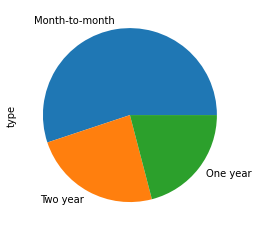

In [75]:
df.type.value_counts().plot(kind='pie')

Большинство клиентов (55%) обслуживаются по месячному контракту, 20% - по годовому и 23% - по двухгодовому. 

In [76]:
df_multiple_lines = df['multiple_lines'].value_counts(normalize = True)
df_multiple_lines

No     0.578072
Yes    0.421928
Name: multiple_lines, dtype: float64

<AxesSubplot:ylabel='multiple_lines'>

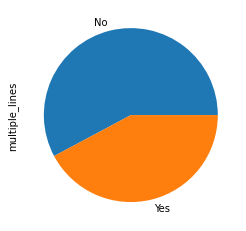

In [77]:
df.multiple_lines.value_counts().plot(kind='pie')

Большинство клиентов (58%) не имеют возможности ведения параллельных линий во время звонка. 

Теперь посмотрим на категориальные признаки в разрезе целевого признака - ушёл или не уёшл клиент. 

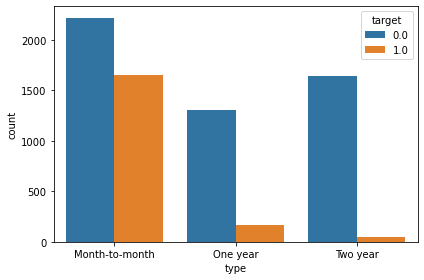

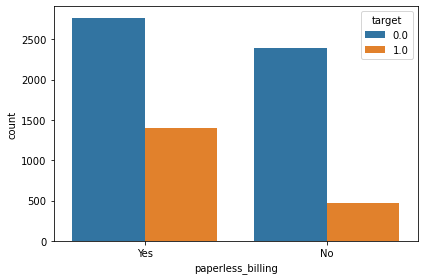

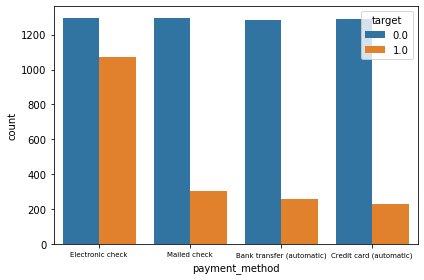

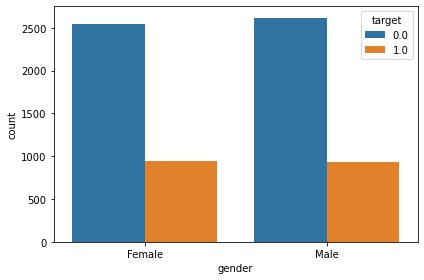

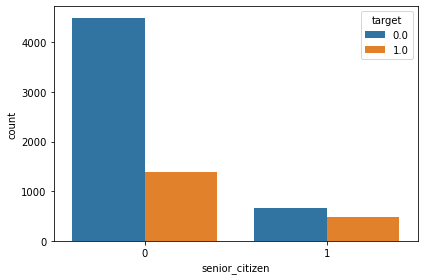

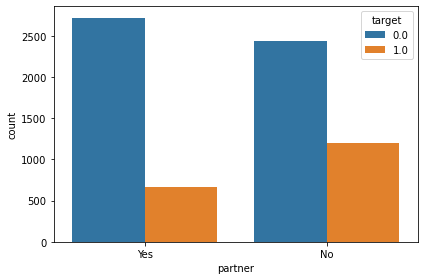

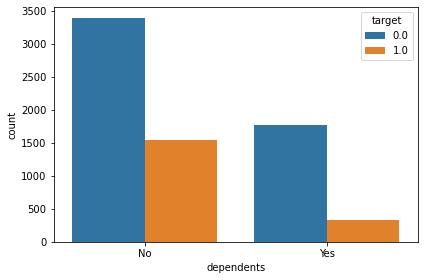

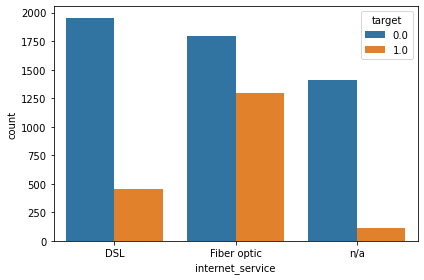

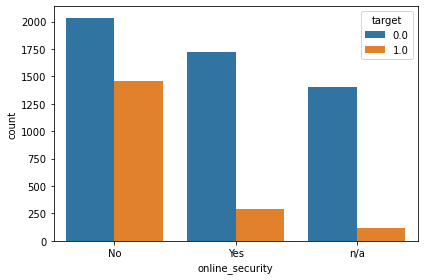

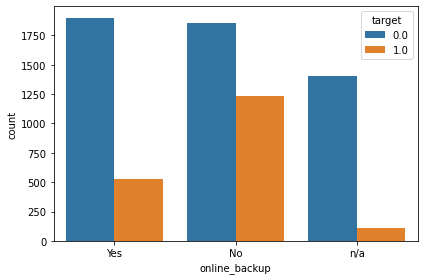

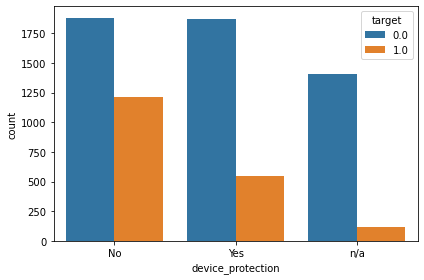

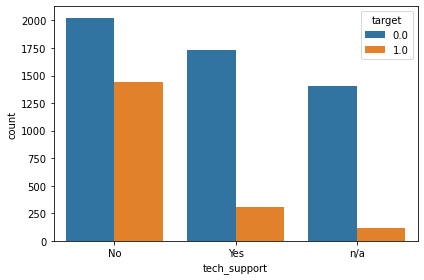

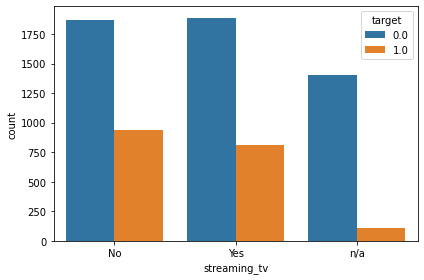

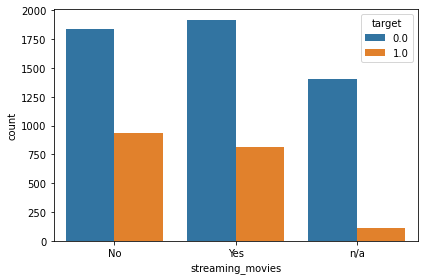

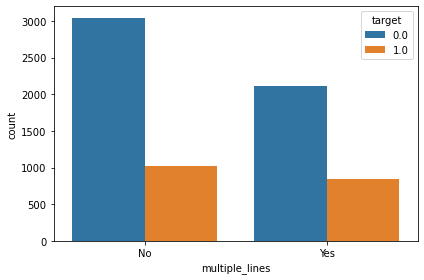

In [78]:
df_cat = df

for i, predictor in enumerate(df_cat.drop(columns=['begin_date', 
                                                   'target', 
                                                   'total_charges', 
                                                   'monthly_charges', 
                                                   'days'])):
    ax = sns.countplot(data =df_cat, x = predictor, hue='target')
    if predictor == "payment_method": 
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
        plt.tight_layout()
        plt.show()
    else:
        plt.tight_layout()
        plt.show()

Гистограммы позволяют сделать следующие выводы:
- клиенты с годовым и двухгодовым контрактом почти не уходят. 
- чаще уходят клиенты, которые предпочетают безналичный расчёт
- уходящие клиенты предпочетают пользоваться электронными чеками в качестве метода оплаты
- гендер не влияет на уход клиента
- если клиент - пенсионер, это повышает его шансы уйти
- шансы уйти у неженатых чуть выше, чем у женатых
- среди тех, кто имеет иждевенцев, шансы расторгнуть контракт меньше, чем среди тех, кто не имеет
- следует обратить особое внимание на пользователей с fiber optic, так как у них шансы уйти выше, чем у пользователей DSL. Возможно в нашей компании есть технические проблемы, не позволяющие обеспечивать высокое качество связи с fiber optic
- если клиент использует защиту онлайн-безопасности или онлайн-бэкап, или защиту девайса, или техническую поддержку (словом, допонительные технические сервисы),  то шансы, что он уйдёт, значительно меньше
- различия между клиентами, использующими или неиспользующими стриминг тв и фильмов есть, но не считаем их значительными
- шансы уйти у тех, кто не имеет возможности ведения параллельных линий во время звонка, чуть меньше, чем у тех, кто имеет. 

Теперь обратимся к числовым признакам.

In [79]:
def num_plot(feature):
    fig, ax = plt.subplots(1, 2, figsize = (12, 4))
    sns.histplot(data = df_1, x = feature, ax = ax[0], color = 'red', kde = True)
    sns.histplot(data = df_0, x = feature, ax = ax[1], color = 'green', kde = True)
    ax[0].set_xlabel(feature, size = 15)
    ax[0].set_ylabel('Количество клиентов', size = 15)
    ax[0].set_title('Ушли', size = 15)
    ax[1].set_xlabel(feature, size = 15)
    ax[1].set_ylabel('Количество клиентов', size = 15)
    ax[1].set_title('Остались', size = 15)
    plt.show()

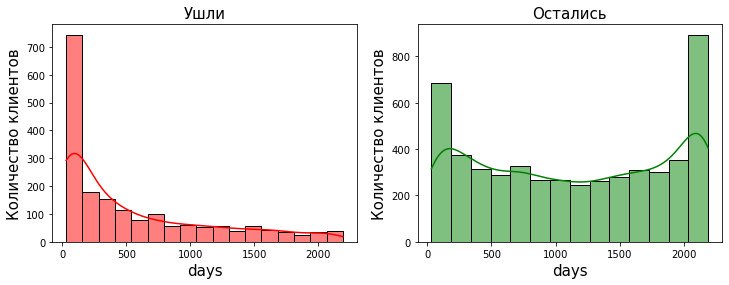

In [80]:
num_plot('days')

Как видим, основной уход клиентов происходит в первые полгода. А среди лояльных клиентов велико количество тех, что с компанией давно - больше 5 лет. Как видим, если клиент не ушёл в первые полгода, то дальше вероятность его ухода резко снижается.

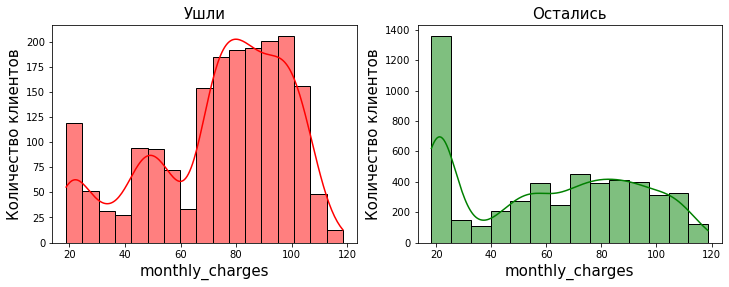

In [81]:
num_plot('monthly_charges')

Среди ушедших клиентов мы видим большое множество тех, кто платит ежемесячно довольно-таки много - от 65 до 110. В то же время, среди лояльных клиентов резко выделяется множество тех, кто платит мало, до 25. Они покидать компанию не спешат. 

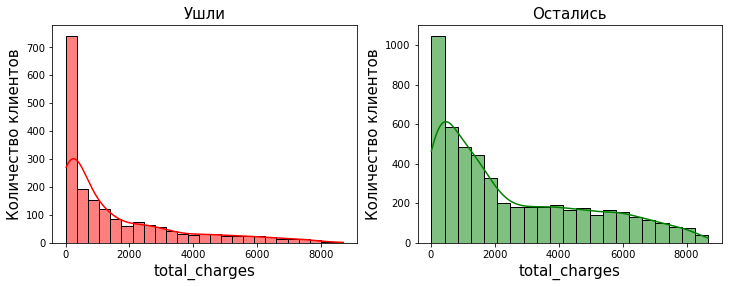

In [82]:
num_plot('total_charges')

Видим, что если клиент суммарно заплатил компании более 500, то его шансы уйти резко снижаются. 

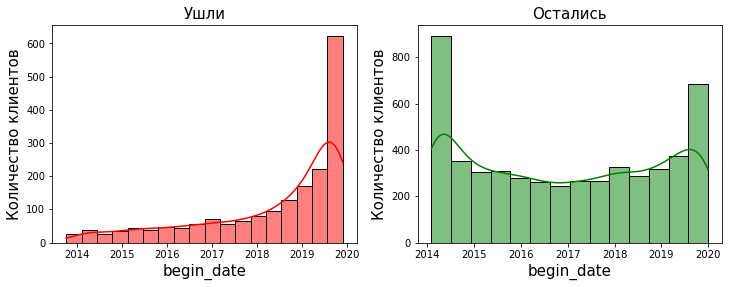

In [83]:
num_plot('begin_date')

Видим, что за последний квартал резко выросло число уходящих клиентов. Но выросло и число остающихся. Возмонжо, просто компания привлекла за это время много клиентов? Проверим. 

<AxesSubplot:>

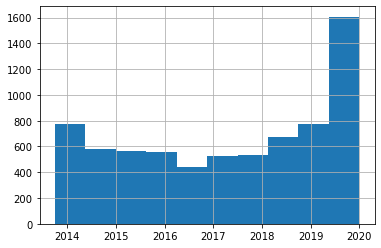

In [84]:
df['begin_date'].hist()

Действительно, с 2018 года количество клиентов неуклонно растёт, особенной большой всплеск наблюдается в последнем квартале 2019 года. Это и отразилось на предыдущих графиках. 

Опишем приблизительный портрет клиента, который с высокой вероятностью расторгнет контракт. 
- месячный контракт
- выбирает безналичный расчёт
- платит электронными чеками
- не имеет иждевенцев
- использует fiber optic
- не пользуется online security, online backup, device protection, tech support, 
- является клиентом компании менее полугода
- в месяц плать от 65 до 110
- суммарно заплатил компании менее 500

Теперь нам необходимо выяснить, нет ли в данных мультиколлинеарности признаков. Для этого высним, как они коррелируют между собой. 

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'days', 'target']


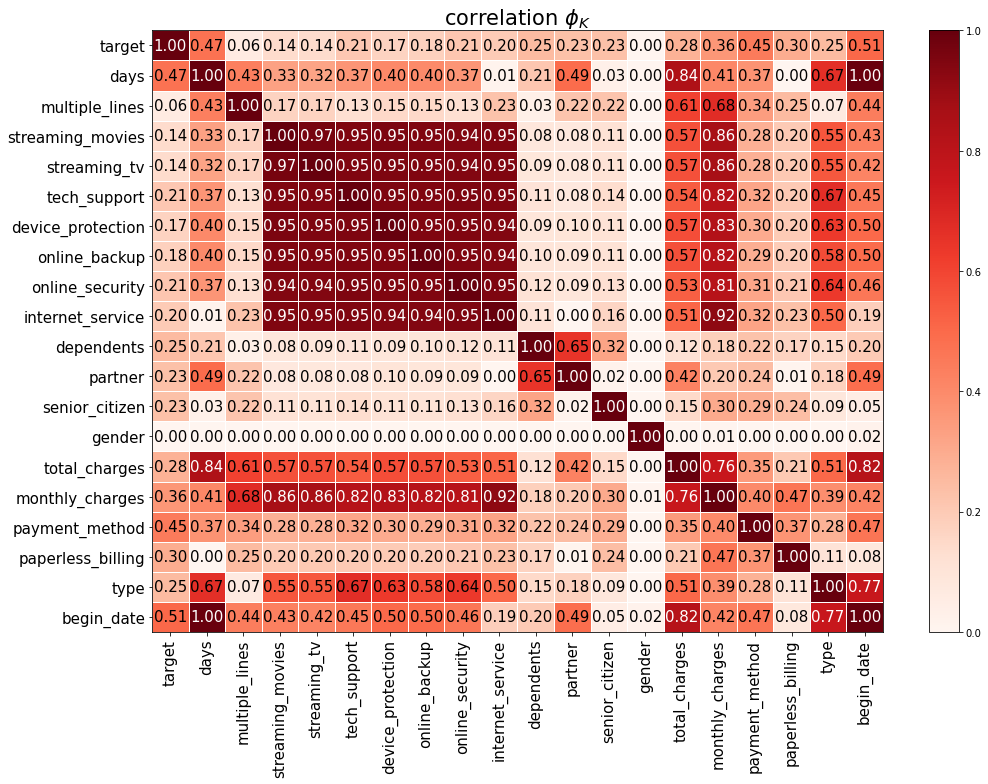

In [85]:
phik_overview = df.phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Reds", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 11))
plt.tight_layout()

Высокую мултиколлинеарность демонстрируют months и total_charges (удалим total_charges, так как он влияет меньше), type и begin_date (удалим type), total_charges и begin_date.
Monthly_charges сильно коррелирует с несколькими признаками, но это объяснимо: чем больше услуг подключает клиент, тем выше оплата в месяц. 
Очень сильно коррелируют с несколькими призанами и между собой streaming_movies, streaming_tv, tech_support, device_protection, online_backup, online_security, internet_service. Это нужно исправить, оставим один признак (internet_security), который влияет на целевой признак сильнее других.  

In [86]:
df = df.drop(['tech_support', 
              'device_protection', 
              'online_backup', 
              'streaming_movies', 
              'streaming_tv', 
              'internet_service', 
              'total_charges', 
              'type'], axis='columns')

interval columns not set, guessing: ['monthly_charges', 'days', 'target']


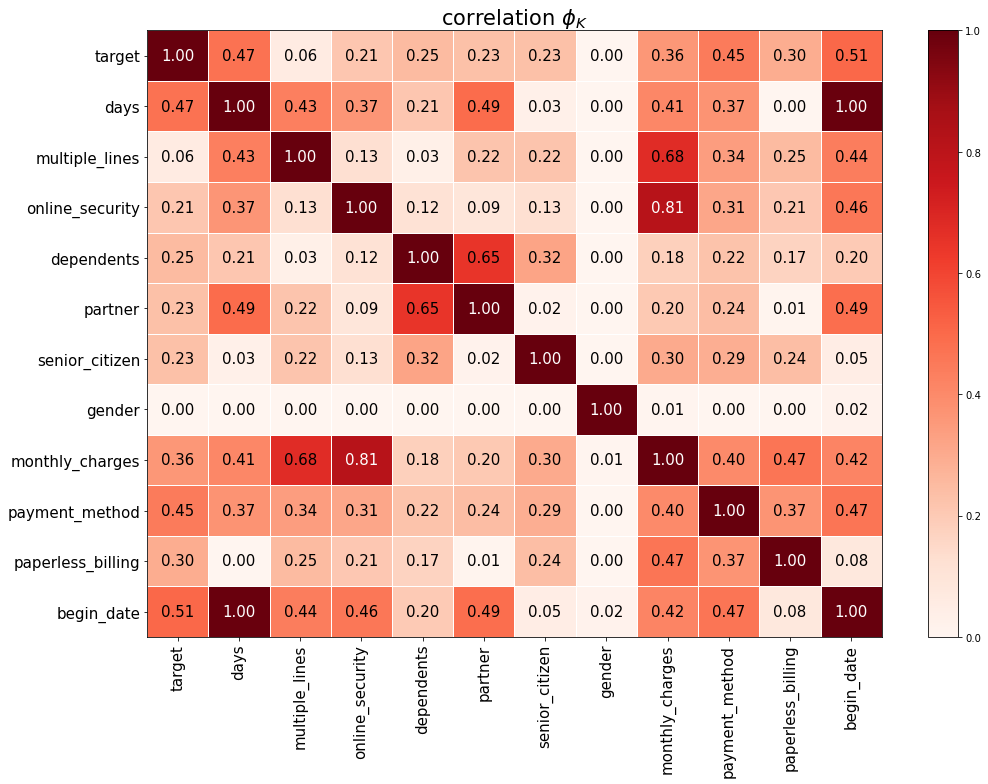

In [87]:
phik_overview = df.phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Reds", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 11))
plt.tight_layout()

Осталась корреляция между online_security и monthly_charges. Придётся избавиться от online_security

In [88]:
df = df.drop(columns='online_security')

Перед моделированием удалим признак begin_date, чтобы не было утечки данных. Также удалим признак gender, так как он практически не влияет на целевой признак. 

In [89]:
df = df.drop(['begin_date', 
              'gender'], axis='columns')

In [90]:
df['senior_citizen'] = df['senior_citizen'].astype('int')

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   paperless_billing  7032 non-null   object 
 1   payment_method     7032 non-null   object 
 2   monthly_charges    7032 non-null   float64
 3   senior_citizen     7032 non-null   int32  
 4   partner            7032 non-null   object 
 5   dependents         7032 non-null   object 
 6   multiple_lines     7032 non-null   object 
 7   days               7032 non-null   int16  
 8   target             7032 non-null   float64
dtypes: float64(2), int16(1), int32(1), object(5)
memory usage: 738.7+ KB


Перед тем, как приступить к моделированию, проверим баланс классов. 

<AxesSubplot:ylabel='target'>

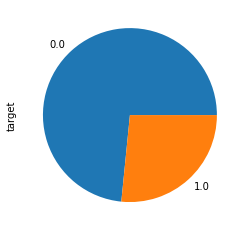

In [92]:
df.target.value_counts().plot(kind='pie')

Есть явный дисбаланс классов. Для некоторых моделей это будет проблемой. Но мы её решим. 

## 4. Моделирование ##

Разделим датасет на обучающую и тестовую выборки. 

In [93]:
target = df['target']
df_train, df_test = train_test_split(df, train_size=0.75, random_state=130223, stratify=target)
features_train = df_train.drop(['target'], axis=1)
target_train = df_train['target']
features_test = df_test.drop(['target'], axis=1)
target_test = df_test['target']

<div class="alert alert-info"> <b>Комментарий студента:</b> Добавила</div>

Далее необходимо масштабировать количественные признаки, чтобы сохранить одинаковый "вес" признаков для алгоритма. 

In [94]:
numeric = ['monthly_charges', 'days']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Теперь кодируем с помощью OHE обучающую и тестовую выборки. Обучаем encoder на тренировочной выборке, а тестовую кодируем

In [95]:
df.columns

Index(['paperless_billing', 'payment_method', 'monthly_charges',
       'senior_citizen', 'partner', 'dependents', 'multiple_lines', 'days',
       'target'],
      dtype='object')

In [96]:
encoder = OneHotEncoder(drop='first')
cat_features = ['paperless_billing',
                'payment_method', 
                'senior_citizen',
                'partner', 
                'dependents', 
                'multiple_lines']
features_train_ohe = encoder.fit_transform(features_train[cat_features])
features_train_ohe = pd.DataFrame(data=features_train_ohe.toarray(), 
                         columns=encoder.get_feature_names().tolist(),
                         index=features_train.index)
features_train_ohe = pd.concat([features_train.drop(cat_features, axis=1), features_train_ohe], axis=1)

#Кодируем тестовую выборку
features_test_ohe = encoder.transform(features_test[cat_features])
features_test_ohe = pd.DataFrame(data=features_test_ohe.toarray(), 
                         columns=encoder.get_feature_names().tolist(),
                         index=features_test.index)
features_test_ohe = pd.concat([features_test.drop(cat_features, axis=1), features_test_ohe], axis=1)




Начинаем моделирование. Будем использовать кросс-валидацию, чтобы выбрать лучшую модель. Сначала попробуем модель случайного леса.

In [97]:
model_forest = RandomForestClassifier()

parametrs_forest = {'n_estimators': range (80, 120, 10),
                    'max_depth': range (5, 10),
                    #'min_samples_split': range (2, 11),
                    'class_weight': ['balanced'],
                   'min_samples_leaf': range (1,4),
                   'random_state' : [130223]}

grid_forest = GridSearchCV(model_forest, parametrs_forest, scoring='roc_auc', cv=5)
grid_forest.fit(features_train_ohe, target_train)
forest_best_score = grid_forest.best_score_
forest_best_parametrs = grid_forest.best_params_
print(forest_best_score)
print(forest_best_parametrs)

0.8498025238791481
{'class_weight': 'balanced', 'max_depth': 8, 'min_samples_leaf': 2, 'n_estimators': 110, 'random_state': 130223}


In [98]:
model_lr = LogisticRegression(random_state=130223, solver='lbfgs')
parametrs_lr = { 'max_iter': range (30, 100, 10),  'C': [0.001,0.01,0.1,1,10,100,1000],}
grid_lr = GridSearchCV(model_lr, parametrs_lr, scoring='roc_auc', cv=5)
grid_lr.fit(features_train_ohe, target_train)
lr_best_score = grid_lr.best_score_
lr_best_parametrs = grid_lr.best_params_
print(lr_best_score)
print(grid_lr.best_params_)

0.8256902860988931
{'C': 0.01, 'max_iter': 30}


In [99]:
for i in features_train:
    features_train[i] = features_train[i].astype('category')
for i in features_test:
    features_test[i] = features_test[i].astype('category')

In [100]:
model_lgb = lgb.LGBMClassifier(random_state=130223)
   

parametrs_lgb = {'boosting_type': ['gbdt', 'dart'],
                           'n_estimators': range (10, 50, 10),
                           'class_weight': ['balanced']}
grid_lgb = GridSearchCV(model_lgb, parametrs_lgb, scoring='roc_auc', cv=5)
grid_lgb.fit(features_train, target_train)
lgb_best_score = grid_lgb.best_score_
lgb_best_parametrs = grid_lgb.best_params_
print(lgb_best_score)
print(lgb_best_parametrs)

0.9417054253035382
{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'n_estimators': 30}


Сравним результаты трёх моделей

In [101]:
data_dict = {'model': ['Случайный лес', 'Логистическая регрессия', 'Градиентный бустинг'],
            'best_score': [forest_best_score,lr_best_score,lgb_best_score]}
pd.DataFrame(data_dict)

,model,best_score
0,Случайный лес,0.849803
1,Логистическая регрессия,0.825690
2,Градиентный бустинг,0.941705


Лучший результат показала модель градиентного бустинга. Её и проверим на тесте. 

In [102]:
model_lgb = lgb.LGBMClassifier(random_state=130223, class_weight = 'balanced', n_estimators = 30)
model_lgb.fit(features_train, target_train)
predictions_test = model_lgb.predict(features_test)
probabilities_test = model_lgb.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
roc_auc = roc_auc_score(target_test, probabilities_one_test)
print('roc_auc наилучшей модели на тестовой выборке:', roc_auc)
accuracy = accuracy_score(target_test, predictions_test)
print('accuracy наилучшей модели на тестовой выборке:', accuracy)


roc_auc наилучшей модели на тестовой выборке: 0.947819445112515
accuracy наилучшей модели на тестовой выборке: 0.8748577929465301


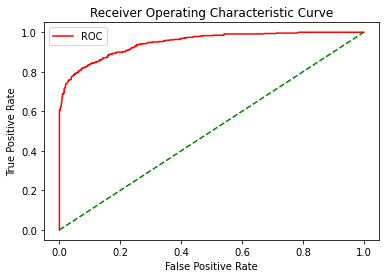

In [103]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
fper, tper, thresholds = metrics.roc_curve(target_test, probabilities_one_test)
plot_roc_curve(fper, tper)

Мы добились необходимого значения roc_auc. Теперь построим матрицу ошибок и проанализируем точность и полноту. 

In [104]:
r = sklearn.metrics.confusion_matrix(target_test, predictions_test)
r = np.flip(r)
print(r)

[[ 395   72]
 [ 148 1143]]


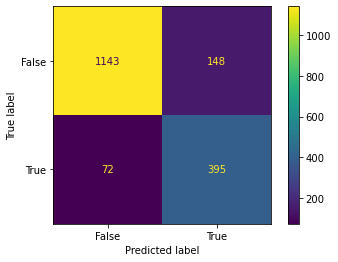

In [105]:
confusion_matrix = metrics.confusion_matrix(target_test, predictions_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

Проанализируем точность и полноту.

In [106]:
precision = sklearn.metrics.precision_score(target_test, predictions_test)
print('Точность модели:', precision)
recall = sklearn.metrics.recall_score(target_test, predictions_test)
print('Полнота модели', recall)

Точность модели: 0.7274401473296501
Полнота модели 0.8458244111349036


Анализ показывает, что модель на 72% верно определяет, что объект принадлежит к верному классу (precision). Полнота ещё лучше - модель распознает 84 из 100 объектов. 

Теперь построим график важности признаков. 

In [107]:
val = model_lgb.feature_importances_

In [108]:
imp_var = []
imp_var_val = []
for i,j in zip(features_train.columns,model_lgb.feature_importances_):
    if j > 0.02:
        imp_var.append(j)
        imp_var_val.append(i)    

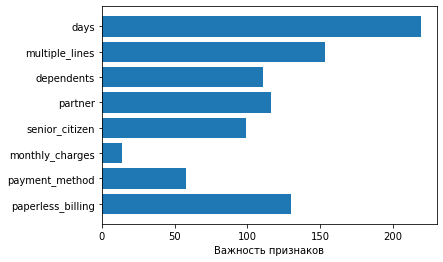

In [109]:
col_name = features_train.columns
plt.barh(col_name,val)
plt.xlabel('Важность признаков')
plt.show()

Итак, мы видим, что наиболее влиятельным признаком оказалось время, которое пользователь является клиентом компании.

В следующем разделе мы приведём основные выводы исследования. 

## 5. Отчет по исследованию ##

### Общие замечания ###

Нами было проведено исследование для оператора связи "Ниединогоразрыва.ком". Целью проекта была разработка модели прогнозирования оттока клиентов компании. Для достижения этой цели нам необходимо было совершить следующие ключевые шаги: обработать данные, провести их исследовательский анализ, испробовать несколько адекватных задаче моделей, выбрать из них лучшую и, в финале, проверить её на тестовой выборке, чтобы убедиться, что метрика качества достаточна для запуска модели в production. Благодаря этой модели мы должны были выяснить важнейшие факторы, которые влияют на отток клиентов компании. 

В начале исследования мы подготовили подробный план работы, основанный на обычном протоколе проведения исследований такого типа. Каждый пункт плана оказался не просто полезен, но и необходим. О трудностях выполнения некоторых шагов плана мы упомянем в  соответствующих разделах отчета. 


### Работа с данными ###

В нашем распоряжении были следующие файлы с данными: 
1) информация о договорах

2) персональные данные клиентов

3) информация об интернет-услугах

4) информация об услугах телефонии

Целевым признаком были данные об окончании контракта клиента с компанией (столбец EndDate в датасете Contract) – дата, когда клиент прекратил контракт, или же указание на то, что не прекратил (дата или No в столбце). 

При ознакомлении с данными выяснилось, что не все клиенты компании пользуются и интернетом, и телефонией. Поэтому после объединения всех таблиц в единый датасет (по признаку customerID) в данных образовались пропущенные значения, которые мы заменили «заглушкой» n/a. Пропуски с столбце total_charges мы заменили той же заглушкой (была идея посчитать, сколько месяцев клиент находится в базе, и умножить на месячный платёж, но мы не знаем, пользовался ли он услугами и, соответственно, платил непрерывно или нет, и менялись ли его тарифные планы. Заполнение могло получиться некорректным, фальсифицирующим данные). Пропуски в столбце multiple_lines скорее всего были связаны с тем, что у клиента недостпуна возможность ведения параллельных линий во время звонка, поэтому мы заменили их значением «No».

Также мы преобразовали названия столбцов согласно змеиному регистру для корректного стиля кода. Далее мы привели форматы хранения данных в соответствие хранимым значениям. При преобразовании столбца total_charges из object во float возникла небольшая проблема: выяснилось, что среди значений присутствуют пробелы. Таких значений было всего 11, и мы приняли решение их удалить, в связи с их малочисленностью. 

Далее мы создали дополнительный признак  – срок «жизни» клиента в компании: мы вычли из даты окончания контракта дату его начала (если контракт ещё не закончился, то мы вычитали из даты выгрузки данных – 1 февраля 2020 года). 

Так данные были готовы к проведению исследовательского анализа.

### Результаты исследовательского анализа ###

Анализ позволил прийти к нескольким интересным выводам:

- клиенты с годовым и двухгодовым контрактом почти не уходят.
- чаще уходят клиенты, которые предпочитают безналичный расчёт
- уходящие клиенты предпочитают пользоваться электронными чеками в качестве метода оплаты
- гендер не влияет на уход клиента
- если клиент - пенсионер, это повышает его шансы уйти
- шансы уйти у неженатых чуть выше, чем у женатых
- среди тех, кто имеет иждивенцев, шансы расторгнуть контракт меньше, чем среди тех, кто не имеет
- следует обратить особое внимание на пользователей с fiber optic, так как у них шансы уйти выше, чем у пользователей DSL. Возможно в нашей компании есть технические проблемы, не позволяющие обеспечивать высокое качество связи с fiber optic
- если клиент использует защиту онлайн-безопасности или онлайн-бэкап, или защиту девайса, или техническую поддержку (словом, дополнительные технические сервисы), то шансы, что он уйдёт, значительно меньше
- основной отток клиентов происходит в первые полгода. А среди лояльных клиентов велико количество тех, что с компанией давно - больше 5 лет. То есть, если клиент не ушёл в первые полгода, то дальше вероятность его ухода резко снижается.
- Среди ушедших клиентов заметно большое множество тех, кто платит ежемесячно довольно-таки много - от 65 до 110. В то же время, среди лояльных клиентов резко выделяется множество тех, кто платит мало, до 25. Они покидать компанию не спешат.
- Если клиент суммарно заплатил компании более 500, то его шансы уйти резко снижаются.

Благодаря проведению исследовательского анализа мы смогли обрисовать приблизительный портрет «уходящего» клиента:

- месячный контракт
- выбирает безналичный расчёт
- платит электронными чеками
- не имеет иждевенцев
- использует fiber optic
- не пользуется дополнительными интернет-сервисами (online security, online backup, device protection, tech support)
- является клиентом компании менее полугода
- в месяц платит от 65 до 110
- суммарно заплатил компании менее 500

Далее мы проверяли признаки на мультиколлинеарность (наличие линейной зависимости, сильной корреляции между признаками – такая зависимость будет негативно влиять на качество модели, предсказания будут неустойчивыми). Мы построили корреляционную матрицу и после её анализа удалили все лишние признаки ('tech_support', 'device_protection', 'online_backup', 'streaming_movies', 'streaming_tv', 'internet_service', 'total_charges', 'type', 'online_security'). Также на этом этапе мы удалили признаки 'gender' (так как он практически не влияет на целевой признак) и 'begin_date' (так как он провоцировал бы утечку данных).

Также перед моделированием мы проверили баланс классов. Выяснилось, что в данных присутствует дисбаланс, который мы должны будем учесть при разделении выборок перед обучением.   


### Моделирование ###

Таким образом, при обучении моделей мы использовали следующие признаки: безналичный расчет, способ оплаты, ежемесячные траты на услуги, является ли клиент пенсионером, в браке ли клиент, имеет ли клиент иждивенцев, есть ли у клиента возможность ведения параллельных линий во время звонка и сколько клиент является клиентом компании. Мы отобрали эти признаки на этапе исследовательского анализа, руководствуясь матрицей корреляции. 

После разделения данных на обучающую и тестовую выборки (в пропорции 75% на 25% соответственно) мы провели масштабирование количественных признаков (StandardScaler) и кодирование категориальных (OneHotEncoder).

В качестве моделей мы выбрали модель случайного леса, логистическую регрессию и градиентный бустинг (LGBMClassifier). Первые две модели мы обучали на закодированных данных, а последнюю – на изначальных, изменив тип признаков на category. Чтобы выбрать лучшую модель, мы использовали кросс-валидацию (GridSearchCV). 

Модели показали следующие результаты:

In [110]:
pd.DataFrame(data_dict)

,model,best_score
0,Случайный лес,0.849803
1,Логистическая регрессия,0.825690
2,Градиентный бустинг,0.941705


Лучший результат показала модель градиентного бустинга со следующими параметрами: random_state=130223, class_weight = 'balanced', n_estimators = 30. Её мы проверили на тестовой выборке и получили следующие результаты: 

roc_auc наилучшей модели на тестовой выборке: 0.947819445112515

accuracy наилучшей модели на тестовой выборке: 0.8748577929465301

По результатам обучения мы построили график ROC-кривой.


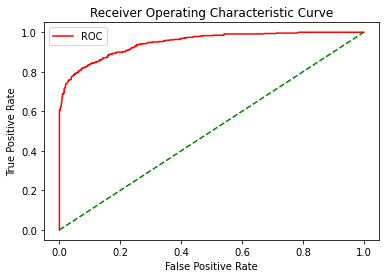

In [111]:
plot_roc_curve(fper, tper)

Этот график показывает соотношение между долей объектов от общего количества носителей признака, верно классифицированных как несущие признак, и долей объектов от общего количества объектов, не несущих признака, ошибочно классифицированных как несущие признак. Мы должны оценить площадь между roc-кривой и осью доли ложных положительных классификаций (диагональ на графике). Чем ближе roc-кривая к диагонали, тем хуже модель. Наша же площадь кривой приближается к 1, это хороший показатель качества модели.

Также для оценки качества модели мы использовали матрицу ошибок и проанализировали точность и полноту модели. 

Точность модели (доля клиентов действительно уходящих относительно всех клиентов, которые модель отнесла к уходящим) – 72%. Полнота модели (доля найденных моделью уходящих клиентов относительно всех уходящих клиентов в выборке) – 84%. 

Далее мы построили график важности признаков для успешной модели.

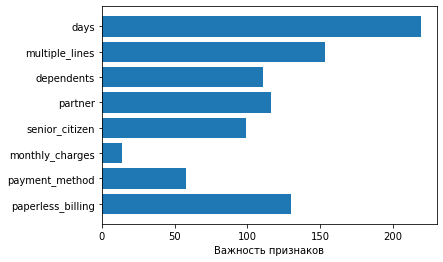

In [112]:
col_name = features_train.columns
plt.barh(col_name,val)
plt.xlabel('Важность признаков')
plt.show()

Выяснилось, что наиболее влиятельным признаком оказалось время, которое пользователь является клиентом компании. Чуть менее, но всё же достаточно сильно важны возможность ведения параллельных линий, безналичный расчет, является ли клиент пенсионером, состоит ли в браке и имеет ли иждивенцев. Способ оплаты и сумма ежемесячных платежей продемонстрировали меньшее влияние. 

### Финальные выводы ###

Итак, мы разработали модель, которая предсказывает отток клиентов компании. Несмотря на то что в исследовательском анализе мы обрисовали «портрет» уходящего клиента, далеко не все черты этого «портрета» необходимы для прогноза. Достаточно использовать только те признаки, на которых мы в итоге обучали модели (безналичный расчет, способ оплаты, ежемесячные траты на услуги, является ли клиент пенсионером, в браке ли клиент, имеет ли клиент иждивенцев, есть ли у клиента возможность ведения параллельных линий во время звонка и сколько клиент является клиентом компании.). Самым важным признаком оказалось время, которое пользователь является клиентом компании. Чем раньше пользователь стал нашим клиентом, тем меньше вероятность его ухода. Поэтому в маркетинговых акциях стоит обратить особое внимание на клиентов, которые в компании менее полугода.

Однако исследовательский анализ выявил важный, на наш взгляд, момент: возможно в нашей компании есть технические проблемы, не позволяющие обеспечивать высокое качество связи с fiber optic, пользователи с fiber optic уходят гораздо чаще, чем пользователи с DSL. 
